<a href="https://colab.research.google.com/github/grace3999/MedPC/blob/master/Carlson_MED_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Variable Definitions

- T   = event time stamp
- E   = event identity stamp

### Event Stamps

#### Trial bits
- start session: 6   - Houselight on (7   - Houselight off)
- delay starts: 23  - Delay starts (24  - Delay ends)
- start ITI: 12  - Intertrial interval begins (13  - Intertrial interval ends)
- session ends: 100 - Session ends

#### Trial bits
- 5   - Reward pellet delivery - happends during ITI
- 14  - Head entry into food tray
- 25  - Head entry for reward - happens during ITI
- 8   - Right lever extends (9   - Right lever retracts)
- 10  - Left lever extends (11  - Left lever retracts)
- 1   - Right lever press
- 2   - Left lever press
- 3   - Rewarded right lever press
- 4   - Rewarded left lever press
- 15  - Correct alternation to right
- 16  - Correct alternation to left
- 17  - Incorrect alternation to right
- 18  - Incorrect alternation to left
- 19  - Correct perseveration on right for reversal session
- 20  - Correct perseveration on left for reversal session
- 21  - Incorrect perseveration on right for reversal session
- 22  - Incorrect perseveration on left for reversal session

In [3]:
def get_file_info_common(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session, saves each accordingly
    
    task = file_path_name.split('/')[-2]
    animal = file_path_name.split('/')[-1].split(' ')[-1].split('.txt')[0]
    date = file_path_name.split('/')[-1].split('_')[0]

    return task, animal, date

In [4]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [5]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(event_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        elif re.search(time_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    time_data.append(float(element))
                if i==len(array)-1:
                  break
                else:
                  i = i + 1
        else:
            i = i + 1

    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [6]:
def get_trial_times_LPD(events_and_times, trial_start_list, delay_start_list, ITI_start_list):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for start and end of trial segment
    #e.g. session onset and offset, ITI onset and offset - here both levers extend so can just use right lever as start
    #finds time_stamps for each start and end, puts into new dataframe
    import numpy as np
    import pandas as pd

    trial_start_times = list(events_and_times[events_and_times['event_stamp'].isin(trial_start_list)]['time_stamp'].drop_duplicates().values)
    delay_start_times = list(events_and_times[events_and_times['event_stamp'].isin(delay_start_list)]['time_stamp'].drop_duplicates().values)
    ITI_start_times = list(events_and_times[events_and_times['event_stamp'].isin(ITI_start_list)]['time_stamp'].drop_duplicates().values)
    ITI_end_times = trial_start_times[1:]

    times = pd.DataFrame(data = [trial_start_times, delay_start_times, ITI_start_times, ITI_end_times])
    times = times.T
    times.columns = ['trial_start', 'delay_start', 'ITI_start', 'ITI_end']
    
    return times

In [7]:
def create_trial_df(events_and_times, trial_times, trial_type):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    if trial_type == 'first':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] < trial_times['delay_start'][i])]
            data['trial_#'] = [i]*len(data)
            data['trial_start'] = trial_times['trial_start'][i]
            data['trial_end'] = trial_times['delay_start'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    elif trial_type == 'delay':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['delay_start'][i]) & (events_and_times['time_stamp'] < trial_times['ITI_start'][i])]
            data['trial_#'] = [i]*len(data)
            data['delay_start'] = trial_times['delay_start'][i]
            data['delay_end'] = trial_times['ITI_start'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    elif trial_type == 'ITI':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['ITI_start'][i]) & (events_and_times['time_stamp'] <= trial_times['ITI_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['ITI_start'] = trial_times['ITI_start'][i]
            data['ITI_end'] = trial_times['ITI_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1

    return trial_data

In [8]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [9]:
def latency(trial_data, event_num, trial_type):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_IRT = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_IRT.append(np.nan)
        else:
            if trial_type == 'first':
                latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
                latency_IRT.append(data['time_stamp'].diff().mean()/100)
            elif trial_type == 'delay':
                latency_1st.append((data['time_stamp'] - data['delay_start']).values[0]/100)
                latency_IRT.append(data['time_stamp'].diff().mean()/100)
            if trial_type == 'ITI':
                latency_1st.append((data['time_stamp'] - data['ITI_start']).values[0]/100)
                latency_IRT.append(data['time_stamp'].diff().mean()/100)
            
        i = i + 1
    
    return latency_1st, latency_IRT

In [10]:
def create_session_df(trial_data, event_dic, trial_type):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    if trial_type == 'first':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
        times_df = times_df.T  
    elif trial_type == 'delay':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['delay_start'].unique(), trial_data.groupby('trial_#')['delay_end'].unique()])
        times_df = times_df.T  
    elif trial_type == 'ITI':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['ITI_start'].unique(), trial_data.groupby('trial_#')['ITI_end'].unique()])
        times_df = times_df.T

    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        if trial_type == 'first':
            trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])/100
        elif trial_type == 'delay':
            trial_time = (times_df.iloc[i]['delay_end'] - times_df.iloc[i]['delay_start'])/100
        elif trial_type == 'ITI':
            trial_time = (times_df.iloc[i]['ITI_end'] - times_df.iloc[i]['ITI_start'])/100
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_IRT')] = latency(trial_data, event, trial_type)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times

    if session_data.shape[0]==0:
      print('No trials completed!/n')
      session_data['trial_num'] = [0]
      session_data['reinforcement_count'] = [0]
      session_data['right_lever_count'] = [0]
      session_data['left_lever_count'] = [0]

    return session_data

### Read in animal meta data

In [11]:
meta_path = '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/Carlson_FP_meta.xlsx'

data_meta = pd.read_excel(meta_path)

data_meta = pd.DataFrame(data = data_meta)
data_meta['animal'] = [str(x).split('.')[0] if isinstance(x, float) else str(x) for x in data_meta['animal']]
print(data_meta.shape)

data_meta.tail()

(24, 4)


,animal,sensor,region,cohort
19,Lox074.1,dopamine,NAc,7
20,Lox074.2,norepi,NAc,7
21,Lox074.3,dopamine,NAc,7
22,Lox075.1,dopamine,CB,7
23,Lox075.2,norepi,CB,7


### Get file paths

In [12]:
path ='/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA'

file_names = os.listdir(path)
print(len(file_names))

file_paths = []

for file in file_names:
    
    file_path = path + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0:10]

79
79


['/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_08h58m_Subject 1283.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_10h40m_Subject 1338.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_12h37m_Subject 1341.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_14h17m_Subject 1343.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_15h50m_Subject 1344.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-04_09h04m_Subject 1283.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-04_10h44m_Subject 1338.txt',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carls

### Process files

### Process trial data

In [14]:
first_dic = {'right_lever': 1, 'left_lever': 2, 
             'HE': 14}

delay_dic = {'right_lever': 1, 'left_lever': 2, 
             'HE': 14, 
             'correct_alt_right': 15, 'correct_alt_left': 16, 
             'incorrect_alt_right': 17, 'incorrect_alt_left': 18, 
             }

ITI_dic = {'reinforcement': 5, 
           'right_lever': 1, 'left_lever': 2, 
           'HE_reward': 25, 'HE': 14}

In [15]:
%%time
trial_data = pd.DataFrame()

for file in file_paths:

    print(file) 
    
    if file.split('/')[-1] == '.DS_Store':
        continue
    
    #proccess file
    task, animal, date = get_file_info_common(file)
    print('date:', date, 'animal:', animal, 'task:', task, '\n')
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "E:", "T:")
    trial_times = get_trial_times_LPD(events_and_times, [6], [23], [12])

    first_trial_data = create_trial_df(events_and_times, trial_times, 'first')
    delay_trial_data = create_trial_df(events_and_times, trial_times, 'delay')
    ITI_trial_data = create_trial_df(events_and_times, trial_times, 'ITI')

    first_data = create_session_df(first_trial_data, first_dic, 'first')
    delay_data = create_session_df(delay_trial_data, delay_dic, 'delay')
    ITI_data = create_session_df(ITI_trial_data, ITI_dic, 'ITI')
    
    #create pandas tidy df for within part
    first_data['task'] = [task]*(first_data.shape[0])
    first_data['part'] = ['first']*(first_data.shape[0]) 
    first_data['date'] = [date]*(first_data.shape[0])
    first_data['animal'] = [animal]*(first_data.shape[0])
    
    first_data = first_data[['task', 'part', 'date', 'animal', 
                                 'trial_num', 'trial_duration', 
                                 'HE_count', 'HE_latency_1st', 
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                                 ]]
                       
    #create pandas tidy df for delay part
    delay_data['task'] = [task]*(delay_data.shape[0])
    delay_data['part'] = ['delay']*(delay_data.shape[0]) 
    delay_data['date'] = [date]*(delay_data.shape[0])
    delay_data['animal'] = [animal]*(delay_data.shape[0])
    
    delay_data = delay_data[['task', 'part', 'date', 'animal', 
                                 'trial_num', 'trial_duration', 
                                 'HE_count', 'HE_latency_1st', 
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                             'correct_alt_right_count', 'correct_alt_right_latency_1st',
                             'correct_alt_left_count', 'correct_alt_left_latency_1st',
                             'incorrect_alt_right_count', 'incorrect_alt_right_latency_1st',
                             'incorrect_alt_left_count', 'incorrect_alt_left_latency_1st',
                                 ]]

    #create pandas tidy df for within part
    ITI_data['task'] = [task]*(ITI_data.shape[0])
    ITI_data['part'] = ['ITI']*(ITI_data.shape[0]) 
    ITI_data['date'] = [date]*(ITI_data.shape[0])
    ITI_data['animal'] = [animal]*(ITI_data.shape[0])
    
    ITI_data = ITI_data[['task', 'part', 'date', 'animal', 
                                 'trial_num', 'trial_duration', 
                                 'HE_count', 'HE_latency_1st', 
                         'reinforcement_count', 'reinforcement_latency_1st',
                          'HE_reward_count', 'HE_reward_latency_1st', 
                                 ]]

    #add to final data frame
    data_int = pd.concat([first_data, delay_data], axis = 0, ignore_index=True)
    data_int = pd.concat([data_int, ITI_data], axis = 0, ignore_index=True)
    if trial_data.shape[0] == 0:
        trial_data = data_int
    else:
        trial_data = pd.concat([trial_data, data_int], axis = 0, ignore_index=True)

print(trial_data.shape)
trial_data.tail()

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_08h58m_Subject 1283.txt
date: 2022-04-01 animal: 1283 task: DA 

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_10h40m_Subject 1338.txt
date: 2022-04-01 animal: 1338 task: DA 

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_12h37m_Subject 1341.txt
date: 2022-04-01 animal: 1341 task: DA 

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_14h17m_Subject 1343.txt
date: 2022-04-01 animal: 1343 task: DA 

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-01_15h50m_Subject 1344.txt
date: 2022-04-01 animal: 1344 task: DA 

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-04_09h04m_Subject 1283.txt
date: 2022-04-04 animal: 12

,task,part,date,animal,trial_num,trial_duration,HE_count,HE_latency_1st,right_lever_count,right_lever_latency_1st,left_lever_count,left_lever_latency_1st,correct_alt_right_count,correct_alt_right_latency_1st,correct_alt_left_count,correct_alt_left_latency_1st,incorrect_alt_right_count,incorrect_alt_right_latency_1st,incorrect_alt_left_count,incorrect_alt_left_latency_1st,reinforcement_count,reinforcement_latency_1st,HE_reward_count,HE_reward_latency_1st
26928,DA,ITI,2023-02-21,Lox078.2,96,20.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
26929,DA,ITI,2023-02-21,Lox078.2,97,20.0,1,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,7.13
26930,DA,ITI,2023-02-21,Lox078.2,98,20.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
26931,DA,ITI,2023-02-21,Lox078.2,99,20.0,1,3.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,3.33
26932,DA,ITI,2023-02-21,Lox078.2,100,20.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,3.92


In [19]:
final_trial_data = pd.DataFrame()

for animal in trial_data['animal'].unique():
  print(animal)
  data_int = trial_data[trial_data['animal']==animal]
  date_map = dict(zip(data_int['date'].sort_values().unique(), np.arange(1,len(data_int['date'].unique())+1)))
  data_int['session'] = data_int['date'].map(date_map)
  
  if final_trial_data.shape[0] == 0:
      final_trial_data = data_int
  else:
      final_trial_data = pd.concat([final_trial_data, data_int], axis=0) 
        
  print(final_trial_data.shape)
        
print(final_trial_data.shape)
final_trial_data.head()

1283
(2659, 25)
1338
(4983, 25)
1341
(7112, 25)
1343
(9653, 25)
1344
(11890, 25)
1421
(14170, 25)
1420
(16234, 25)
1686
(17876, 25)
1687
(19604, 25)
1690
(21562, 25)
1689
(23678, 25)
1613
(25471, 25)
1614
(26628, 25)
Lox078.2
(26933, 25)
(26933, 25)


,task,part,date,animal,trial_num,trial_duration,HE_count,HE_latency_1st,right_lever_count,right_lever_latency_1st,left_lever_count,left_lever_latency_1st,correct_alt_right_count,correct_alt_right_latency_1st,correct_alt_left_count,correct_alt_left_latency_1st,incorrect_alt_right_count,incorrect_alt_right_latency_1st,incorrect_alt_left_count,incorrect_alt_left_latency_1st,reinforcement_count,reinforcement_latency_1st,HE_reward_count,HE_reward_latency_1st,session
0,DA,first,2022-04-01,1283,0,11.29,0,NaN,1.0,11.28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,DA,first,2022-04-01,1283,1,17.03,0,NaN,1.0,17.02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,DA,first,2022-04-01,1283,2,8.38,0,NaN,0.0,NaN,1.0,8.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,DA,first,2022-04-01,1283,3,7.57,0,NaN,0.0,NaN,1.0,7.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,DA,first,2022-04-01,1283,4,1.17,0,NaN,1.0,1.16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [20]:
#get single column for lever params (based on active_lever)

final_trial_data['lever_count'] = final_trial_data['right_lever_count'] + final_trial_data['left_lever_count']
final_trial_data['right_lever_latency_1st'] = final_trial_data['right_lever_latency_1st'].replace({np.nan:0})
final_trial_data['left_lever_latency_1st'] = final_trial_data['left_lever_latency_1st'].replace({np.nan:0})
final_trial_data['lever_latency'] = final_trial_data['right_lever_latency_1st'] + final_trial_data['left_lever_latency_1st']

final_trial_data['correct_alt_count'] = final_trial_data['correct_alt_right_count'] + final_trial_data['correct_alt_left_count']
final_trial_data['correct_alt_right_latency_1st'] = final_trial_data['correct_alt_right_latency_1st'].replace({np.nan:0})
final_trial_data['correct_alt_left_latency_1st'] = final_trial_data['correct_alt_left_latency_1st'].replace({np.nan:0})
final_trial_data['correct_alt_latency'] = final_trial_data['correct_alt_right_latency_1st'] + final_trial_data['correct_alt_left_latency_1st']

final_trial_data['incorrect_alt_count'] = final_trial_data['incorrect_alt_right_count'] + final_trial_data['incorrect_alt_left_count']
final_trial_data['incorrect_alt_right_latency_1st'] = final_trial_data['incorrect_alt_right_latency_1st'].replace({np.nan:0})
final_trial_data['incorrect_alt_left_latency_1st'] = final_trial_data['incorrect_alt_left_latency_1st'].replace({np.nan:0})
final_trial_data['incorrect_alt_latency'] = final_trial_data['incorrect_alt_right_latency_1st'] + final_trial_data['incorrect_alt_left_latency_1st']

final_trial_data['alt_count_ratio'] = final_trial_data['correct_alt_count'] / (final_trial_data['correct_alt_count'] + final_trial_data['incorrect_alt_count'])
final_trial_data['alt_latency_ratio'] = final_trial_data['correct_alt_latency'] / (final_trial_data['correct_alt_latency'] + final_trial_data['incorrect_alt_latency'])

final_trial_data = final_trial_data[['task', 'part', 'date', 'session', 'animal', 'trial_num', 'trial_duration',
                                     'HE_count', 'HE_latency_1st', 
                                     'lever_count', 'lever_latency', 'right_lever_count', 'right_lever_latency_1st', 'left_lever_count', 'left_lever_latency_1st', 
                                     'correct_alt_count', 'correct_alt_latency', 'correct_alt_right_count', 'correct_alt_right_latency_1st', 'correct_alt_left_count', 'correct_alt_left_latency_1st', 
                                     'incorrect_alt_count', 'incorrect_alt_latency', 'incorrect_alt_right_count', 'incorrect_alt_right_latency_1st', 'incorrect_alt_left_count', 'incorrect_alt_left_latency_1st', 
                                     'reinforcement_count', 'reinforcement_latency_1st', 'HE_reward_count', 'HE_reward_latency_1st', 
                                     'alt_count_ratio', 'alt_latency_ratio']]
print(final_trial_data.shape)

final_trial_data.head()

(26933, 33)


,task,part,date,session,animal,trial_num,trial_duration,HE_count,HE_latency_1st,lever_count,lever_latency,right_lever_count,right_lever_latency_1st,left_lever_count,left_lever_latency_1st,correct_alt_count,correct_alt_latency,correct_alt_right_count,correct_alt_right_latency_1st,correct_alt_left_count,correct_alt_left_latency_1st,incorrect_alt_count,incorrect_alt_latency,incorrect_alt_right_count,incorrect_alt_right_latency_1st,incorrect_alt_left_count,incorrect_alt_left_latency_1st,reinforcement_count,reinforcement_latency_1st,HE_reward_count,HE_reward_latency_1st,alt_count_ratio,alt_latency_ratio
0,DA,first,2022-04-01,1,1283,0,11.29,0,NaN,1.0,11.28,1.0,11.28,0.0,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,DA,first,2022-04-01,1,1283,1,17.03,0,NaN,1.0,17.02,1.0,17.02,0.0,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,DA,first,2022-04-01,1,1283,2,8.38,0,NaN,1.0,8.37,0.0,0.00,1.0,8.37,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,DA,first,2022-04-01,1,1283,3,7.57,0,NaN,1.0,7.56,0.0,0.00,1.0,7.56,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,DA,first,2022-04-01,1,1283,4,1.17,0,NaN,1.0,1.16,1.0,1.16,0.0,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
session_data = pd.DataFrame()

for animal in final_trial_data['animal'].unique():
  print(animal)
  data_int = final_trial_data[final_trial_data['animal']==animal]

  for session in data_int['session'].unique():
    print(session)
    data_int_session = data_int[data_int['session']==session]

    delay_data_int=data_int_session[data_int_session['part']=='delay']

    correct_alt_right=delay_data_int[delay_data_int['correct_alt_right_count']==1]['trial_num'].values
    data_int_session.loc[data_int_session['trial_num'].isin(correct_alt_right), 'trial_type'] = 'correct_alt_right'

    correct_alt_left=delay_data_int[delay_data_int['correct_alt_left_count']==1]['trial_num'].values
    data_int_session.loc[data_int_session['trial_num'].isin(correct_alt_left), 'trial_type'] = 'correct_alt_left'

    incorrect_alt_right=delay_data_int[delay_data_int['incorrect_alt_right_count']==1]['trial_num'].values
    data_int_session.loc[data_int_session['trial_num'].isin(incorrect_alt_right), 'trial_type'] = 'incorrect_alt_right'

    incorrect_alt_left=delay_data_int[delay_data_int['incorrect_alt_left_count']==1]['trial_num'].values
    data_int_session.loc[data_int_session['trial_num'].isin(incorrect_alt_left), 'trial_type'] = 'incorrect_alt_left'
  
    if session_data.shape[0] == 0:
        session_data = data_int_session
    else:
        session_data = pd.concat([session_data, data_int_session], axis=0) 
        
    print(session_data.shape)
        
print(session_data.shape)
session_data.head()

1283
1
(384, 34)
2
(848, 34)
3
(1306, 34)
4
(1773, 34)
5
(2233, 34)
6
(2659, 34)
1338
1
(2942, 34)
2
(3397, 34)
3
(3797, 34)
4
(4219, 34)
5
(4603, 34)
6
(4983, 34)
1341
1
(5322, 34)
2
(5718, 34)
3
(6095, 34)
4
(6458, 34)
5
(6805, 34)
6
(7112, 34)
1343
1
(7507, 34)
2
(7950, 34)
3
(8396, 34)
4
(8843, 34)
5
(9267, 34)
6
(9653, 34)
1344
1
(9958, 34)
2
(10389, 34)
3
(10821, 34)
4
(11208, 34)
5
(11565, 34)
6
(11890, 34)
1421
1
(12274, 34)
2
(12665, 34)
3
(12954, 34)
4
(13364, 34)
5
(13741, 34)
6
(14170, 34)
1420
1
(14516, 34)
2
(14813, 34)
3
(15225, 34)
4
(15646, 34)
5
(15952, 34)
6
(16234, 34)
1686
1
(16508, 34)
2
(16785, 34)
3
(17052, 34)
4
(17319, 34)
5
(17604, 34)
6
(17876, 34)
1687
1
(18110, 34)
2
(18494, 34)
3
(18770, 34)
4
(19061, 34)
5
(19318, 34)
6
(19604, 34)
1690
1
(19951, 34)
2
(20282, 34)
3
(20618, 34)
4
(20945, 34)
5
(21264, 34)
6
(21562, 34)
1689
1
(21891, 34)
2
(22299, 34)
3
(22662, 34)
4
(23021, 34)
5
(23363, 34)
6
(23678, 34)
1613
1
(23977, 34)
2
(24347, 34)
3
(24620, 34)
4

,task,part,date,session,animal,trial_num,trial_duration,HE_count,HE_latency_1st,lever_count,lever_latency,right_lever_count,right_lever_latency_1st,left_lever_count,left_lever_latency_1st,correct_alt_count,correct_alt_latency,correct_alt_right_count,correct_alt_right_latency_1st,correct_alt_left_count,correct_alt_left_latency_1st,incorrect_alt_count,incorrect_alt_latency,incorrect_alt_right_count,incorrect_alt_right_latency_1st,incorrect_alt_left_count,incorrect_alt_left_latency_1st,reinforcement_count,reinforcement_latency_1st,HE_reward_count,HE_reward_latency_1st,alt_count_ratio,alt_latency_ratio,trial_type
0,DA,first,2022-04-01,1,1283,0,11.29,0,NaN,1.0,11.28,1.0,11.28,0.0,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,incorrect_alt_right
1,DA,first,2022-04-01,1,1283,1,17.03,0,NaN,1.0,17.02,1.0,17.02,0.0,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,incorrect_alt_right
2,DA,first,2022-04-01,1,1283,2,8.38,0,NaN,1.0,8.37,0.0,0.00,1.0,8.37,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,correct_alt_right
3,DA,first,2022-04-01,1,1283,3,7.57,0,NaN,1.0,7.56,0.0,0.00,1.0,7.56,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,correct_alt_right
4,DA,first,2022-04-01,1,1283,4,1.17,0,NaN,1.0,1.16,1.0,1.16,0.0,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,incorrect_alt_right


In [25]:
session_data.to_csv('DA_labeled_trial_data_230316.csv', index=False)

### Process session data

In [ ]:
sum_params = [ 'HE_count', 'lever_count', 'reinforcement_count', 'right_lever_count', 'left_lever_count', 
              'correct_alt_count',  'correct_alt_right_count', 'correct_alt_left_count',
              'incorrect_alt_count', 'incorrect_alt_right_count',  'incorrect_alt_left_count', ]

max_params = ['trial_num']

mean_params = ['trial_duration', 'alt_count_ratio', 'alt_latency_ratio', 
               'HE_latency_1st', 'reinforcement_latency_1st', 'HE_reward_latency_1st', 
               'lever_latency', 'right_lever_latency_1st', 'left_lever_latency_1st', 
               'correct_alt_latency', 'correct_alt_right_latency_1st', 'correct_alt_left_latency_1st', 
               'incorrect_alt_latency', 'incorrect_alt_right_latency_1st', 'incorrect_alt_left_latency_1st']

merge_cols = ['task', 'part', 'date', 'animal',]

data_session_sum = final_trial_data.groupby(merge_cols)[sum_params].sum().reset_index()
data_session_mean = final_trial_data.groupby(merge_cols)[mean_params].mean().reset_index()
data_session_max = final_trial_data.groupby(merge_cols)[max_params].max().reset_index()

data_session_sessiongb = data_session_sum.merge(data_session_mean, on=merge_cols).merge(data_session_max, on=merge_cols)

print(data_session_sessiongb.shape)
data_session_sessiongb.head()

(3, 31)


,task,part,date,animal,HE_count,lever_count,reinforcement_count,right_lever_count,left_lever_count,correct_alt_count,correct_alt_right_count,correct_alt_left_count,incorrect_alt_count,incorrect_alt_right_count,incorrect_alt_left_count,trial_duration,alt_count_ratio,alt_latency_ratio,HE_latency_1st,reinforcement_latency_1st,HE_reward_latency_1st,lever_latency,right_lever_latency_1st,left_lever_latency_1st,correct_alt_latency,correct_alt_right_latency_1st,correct_alt_left_latency_1st,incorrect_alt_latency,incorrect_alt_right_latency_1st,incorrect_alt_left_latency_1st,trial_num
0,DA,ITI,2023-02-21,Lox078.2.txt,41,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.000000,NaN,NaN,5.511429,0.0,2.371864,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,100
1,DA,delay,2023-02-21,Lox078.2.txt,10,102.0,0.0,60.0,42.0,61.0,39.0,22.0,41.0,21.0,20.0,16.495980,0.598039,0.598039,5.400000,NaN,NaN,16.485980,10.841275,5.644706,9.64,6.395392,3.244608,6.84598,4.445882,2.400098,101
2,DA,first,2023-02-21,Lox078.2.txt,8,102.0,0.0,43.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,16.525784,NaN,NaN,7.925000,NaN,NaN,16.515784,5.711078,10.804706,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,101


In [ ]:
animals = [2020., 2021., 2022., 2023., 2024., 2025., 2026., 2027., 2028.,
       2029., 2030., 2031., 2032., 2033., 2034., 2035., 2036., 2037.,
       2038., 2039., 2040., 2041., 2042., 2043., 2044., 2045., 2046.,
       2047., 2048., 2049., 2050., 2052., 2054., 2055., 2056., 2057.,
       2058., 2059., 2060., 2061., 2062., 2063., 2064., 2065., 2066.,
       2069., 2070., 2071., 2072., 2073., 2074., 2075., 2076., 2077.,
       2078., 2079., 2080., 2081., 2085., 2086., 2088., 2089., 2091.]

animals_meta = animal_info['animal'].unique()
print(set(animals) - set(animals_meta))

animals_data = data_session_sessiongb['animal'].unique()
print(set(animals) - set(animals_data))
print(set(animals_data) - set(animals))

set()
{2059.0}
set()


In [ ]:
data_session_sessiongb.head()

,task,part,session,date,cohort,animal,group,active_lever,reinforcement_count,HE_count,active_lever_count,inactive_lever_count,total_lever,reinforcement_latency_1st,reinforcement_latency_IRT,HE_latency_1st,HE_latency_IRT,active_lever_latency_1st,active_lever_latency_IRT,inactive_lever_latency_1st,inactive_lever_latency_IRT,DI,efficiency,trial_duration,trial_num
0,LPD,ITI,1,230202,dynorphin,2020,SV,Left,0,1.0,0,0,0,NaN,NaN,16.9099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9998,0
1,LPD,ITI,1,230202,dynorphin,2021,SV,Left,0,2.0,0,0,0,NaN,NaN,16.5499,0.030,NaN,NaN,NaN,NaN,NaN,NaN,29.9998,3
2,LPD,ITI,1,230202,dynorphin,2026,BV,Right,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.4998,1
3,LPD,ITI,1,230202,dynorphin,2027,BV,Right,0,3.0,0,0,0,NaN,NaN,39.0499,0.155,NaN,NaN,NaN,NaN,NaN,NaN,44.9998,0
4,LPD,ITI,1,230202,dynorphin,2028,BV,Right,0,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.9998,4


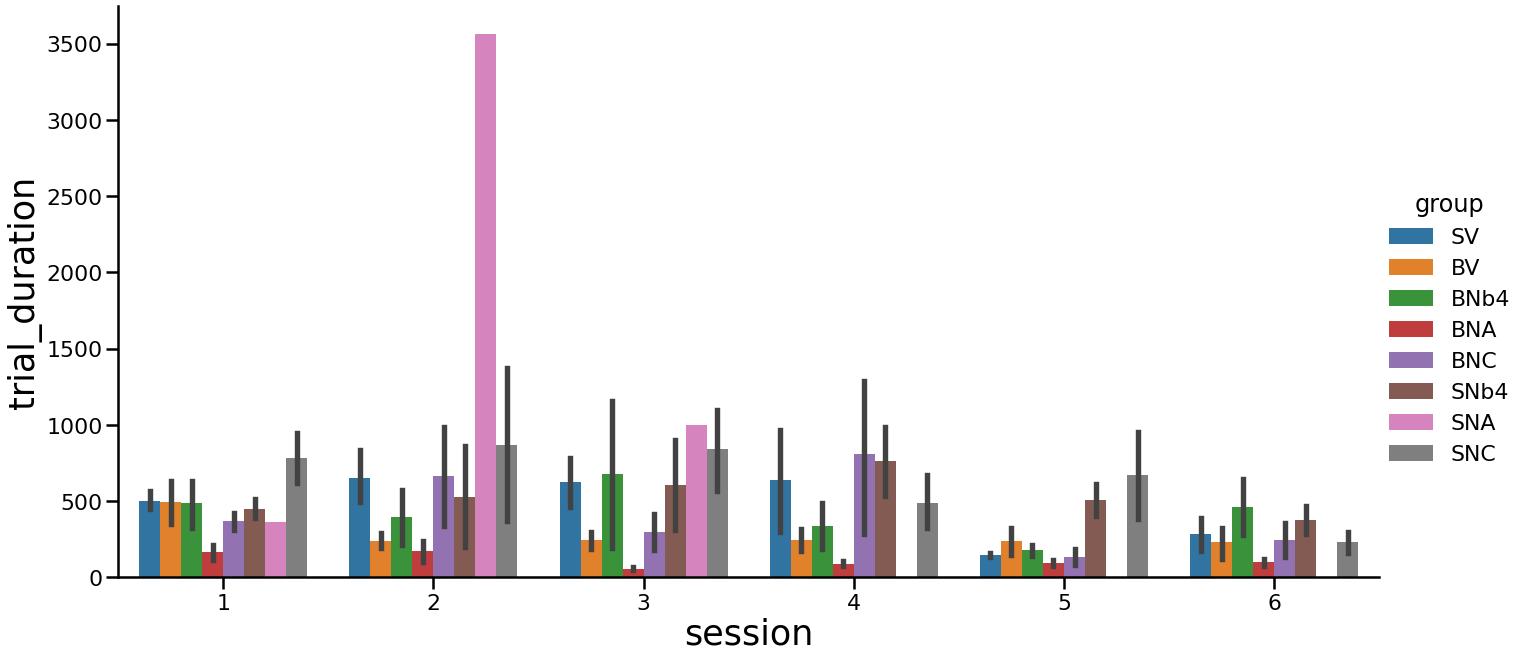

In [ ]:
order = ['SV', 'BV', 'BNb4', 'BNA', 'BNC', 'SNb4', 'SNA', 'SNC']
d=data_session_sessiongb
animals_3 = [2039., 2040., 2056., 2057., 2058., 2080., 2023., 2024., 2025.,
       2029., 2030., 2031., 2032., 2034., 2037., 2043., 2045., 2047.,
       2048., 2049., 2050., 2052., 2055., 2062., 2063., 2069., 2070.,
       2071., 2072., 2073., 2074., 2076., 2081., 2085., 2028., 2033.,
       2036., 2041., 2044., 2046., 2054., 2064., 2089., 2091., 2035.,
       2042.]
#d=d[d['animal'].isin(animals_3)]

#d=data_session_sessiongb[data_session_sessiongb['session']==5]
d=d[d['part']=='within']
sns.catplot(x='session', y='trial_duration', data=d, kind='bar', ci=68, 
            height=10, aspect=2, hue='group', hue_order=order)
plt.show()

In [ ]:
data_session_sessiongb_melt = data_session_sessiongb.set_index(['cohort', 'task', 'part', 'animal', 'group', 'session']).unstack(-1).reset_index()
data_session_sessiongb_melt = data_session_sessiongb_melt.sort_values(['task', 'part', 'group', 'cohort', 'animal', ])
data_session_sessiongb_melt.tail()

cohort task    part animal group    date                                         active_lever                                    reinforcement_count                               HE_count                                 active_lever_count                               inactive_lever_count                              total_lever                               reinforcement_latency_1st                                                              reinforcement_latency_IRT                     HE_latency_1st                                                     HE_latency_IRT                                                        active_lever_latency_1st                                                              active_lever_latency_IRT                     inactive_lever_latency_1st                                                          inactive_lever_latency_IRT                                                       DI                                                   efficiency                                                   trial_duration                                                              trial_num                              
session                                            1       2       3       4       5       6            1      2      3      4      5      6                   1     2     3     4     5     6        1     2     3     4      5      6                  1     2     3     4     5     6                    1     2     3     4    5     6           1     2     3     4     5     6                         1            2           3           4           5           6                         1   2   3   4   5   6              1        2           3        4          5          6              1          2          3          4          5          6                        1            2           3           4           5           6                        1   2   3   4   5   6                          1           2           3           4          5         6                          1       2          3         4         5       6         1         2         3         4         5         6          1         2         3         4         5         6              1            2           3           4           5           6         1     2     3     4     5     6
99       dynorphin  LPD  within   2060    SV  230203  230227  230228     NaN     NaN     NaN         Left   Left   Left    NaN    NaN    NaN                 4.0   2.0   0.0   NaN   NaN   NaN     81.0  43.0   0.0   NaN    NaN    NaN                4.0   2.0   0.0   NaN   NaN   NaN                  0.0   3.0   0.0   NaN  NaN   NaN         4.0   5.0   0.0   NaN   NaN   NaN                569.182500  1561.710000         NaN         NaN         NaN         NaN                       NaN NaN NaN NaN NaN NaN     198.476667  189.725         NaN      NaN        NaN        NaN      13.268193  59.235854        NaN        NaN        NaN        NaN               569.172500  1561.700000         NaN         NaN         NaN         NaN                      NaN NaN NaN NaN NaN NaN                        NaN  646.855000         NaN         NaN        NaN       NaN                        NaN    1.08        NaN       NaN       NaN     NaN  1.000000 -0.166667       NaN       NaN       NaN       NaN   1.000000  0.416667       NaN       NaN       NaN       NaN     569.182500  1561.710000         NaN         NaN         NaN         NaN       3.0   1.0   0.0   NaN   NaN   NaN
100      dynorphin  LPD  within   2061    SV  230202  230203  230227  230228     NaN     NaN        Right  Right  Right  Right    NaN    NaN                 3.0   0.0   8.0   6.0   NaN   NaN     24.0   0.0  32.0  35.0    NaN    NaN                3.0   0.0   8.0   6.0   NaN   NaN                  4.0   0.0  12.0  10.0  NaN   NaN         7.0   0.0  20.0  16.0   NaN   NaN                534.630000          NaN  404.583750  647.256667         NaN         NaN                       NaN NaN NaN NaN NaN NaN

In [ ]:
data_session_sessiongb_melt.to_csv('LPD_melt.csv', index=False)

### Single for refactor

In [ ]:
file_path = file_paths[0]
print('file_path:', '\n', file_path, '\n')

task, animal, date = get_file_info_common(file_path)
print('date:', date, 'animal:', animal, 'task:', task, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "E:", "T:")
print(events_and_times.head(), '\n')

trial_times = get_trial_times_LPD(events_and_times, [6], [23], [12])
print(trial_times.head(), '\n')

first_trial_data = create_trial_df(events_and_times, trial_times, 'first')
print(first_trial_data.head(), '\n')

delay_trial_data = create_trial_df(events_and_times, trial_times, 'delay')
print(delay_trial_data.head(), '\n')

ITI_trial_data = create_trial_df(events_and_times, trial_times, 'ITI')
print(ITI_trial_data.head(), '\n')

first_dic = {'right_lever': 1, 'left_lever': 2, 
             'HE': 14}
first_data = create_session_df(first_trial_data, first_dic, 'first')

delay_dic = {'right_lever': 1, 'left_lever': 2, 
             'HE': 14, 
             'correct_alt_right': 15, 'correct_alt_left': 16, 
             'incorrect_alt_right': 17, 'incorrect_alt_left': 18, 
             'left_lever': 2,}
delay_data = create_session_df(delay_trial_data, delay_dic, 'delay')

ITI_dic = {'reinforcement': 5, 
           'right_lever': 1, 'left_lever': 2, 
           'HE_reward': 25, 'HE': 14}
ITI_data = create_session_df(ITI_trial_data, ITI_dic, 'ITI')

file_path: 
 /content/drive/Shareddrives/Schindler Iterative Translation Lab/data/Carlson_Lab/data/MED/DA/2022-04-07_14h11m_Subject 1343.txt 

date: 2022-04-07 animal: 1343 task: DA 

[['Start Date: 04/07/22']
 ['End Date: 04/07/22']
 ['Subject: 1343']
 ['Experiment: DA.D5']
 ['Group: FibPhotGroup4_F_Pcp2-Cre']] 

   event_stamp  time_stamp
0          6.0         0.0
1          8.0         0.0
2         10.0         0.0
3          1.0       874.0
4          9.0       875.0 

   trial_start  delay_start  ITI_start  ITI_end
0          0.0        875.0     1986.0   3986.0
1       3986.0       4526.0     5571.0   7571.0
2       7571.0       7726.0     8783.0  10783.0
3      10783.0      11096.0    12269.0  14269.0
4      14269.0      15012.0    16085.0  18085.0 

   event_stamp  time_stamp  trial_#  trial_start  trial_end
0          6.0         0.0        0          0.0      875.0
1          8.0         0.0        0          0.0      875.0
2         10.0         0.0        0          0.0  